In [48]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import imageio
from pathlib import Path

from tqdm import tqdm, tqdm_pandas
tqdm.pandas()

In [15]:
%%time

train = pd.read_csv('data/bms-molecular-translation/train_labels.csv')
test = pd.read_csv('data/bms-molecular-translation/sample_submission.csv')

display(train.head())
display(test.head())

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


CPU times: user 4.64 s, sys: 359 ms, total: 5 s
Wall time: 5.48 s


In [16]:
def get_train_file_path(image_id):
    return "data/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

def get_test_file_path(image_id):
    return "data/bms-molecular-translation/test/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )



In [17]:
train['file_path'] = train['image_id'].progress_apply(get_train_file_path)
test['file_path'] = test['image_id'].progress_apply(get_test_file_path)

print(f'train.shape: {train.shape}  test.shape: {test.shape}')

100%|██████████| 1616107/1616107 [00:01<00:00, 839109.40it/s]

train.shape: (2424186, 3)  test.shape: (1616107, 3)


In [18]:
data = pd.concat([test,train], ignore_index=True)

In [19]:
data.head()

,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
1,00001f7fc849,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
2,000037687605,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
3,00004b6d55b6,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...
4,00004df0fe53,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...


In [20]:
data.loc[0,"file_path"]

'data/bms-molecular-translation/test/0/0/0/00000d2a601c.png'

In [21]:
image = imageio.imread(data.loc[0,"file_path"])

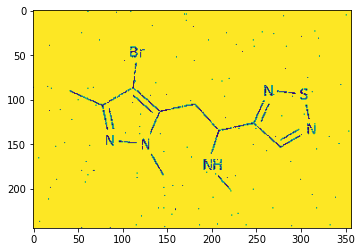

In [22]:
plt.imshow(image)

In [23]:
",".join([str(i) for i in np.unique(image)])

'0,255'

In [24]:
image.shape

(244, 357)

In [25]:
def extract_stats(row):
    image = imageio.imread(row["file_path"])
    row["height"] = image.shape[0]
    row["length"] = image.shape[1]
    row["values"] = ",".join([str(i) for i in np.unique(image)])
    return row

In [26]:
data = data.progress_apply(extract_stats, axis=1)

100%|██████████| 4040293/4040293 [4:58:12<00:00, 225.81it/s]    


In [27]:
import pickle

In [28]:
pickle.dump(data, open("data.pkl", "wb"))

In [29]:
data.head()

,image_id,InChI,file_path,height,length,values
0,00000d2a601c,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...,244,357,"0,255"
1,00001f7fc849,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...,440,265,"0,255"
2,000037687605,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...,388,302,"0,255"
3,00004b6d55b6,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...,230,415,"0,255"
4,00004df0fe53,InChI=1S/H2O/h1H2,data/bms-molecular-translation/test/0/0/0/0000...,256,216,"0,255"


In [30]:
data.height.max()

3010

In [31]:
data.length.max()

3078

In [33]:
data["values"].unique()

array(['0,255'], dtype=object)

<AxesSubplot:ylabel='Frequency'>

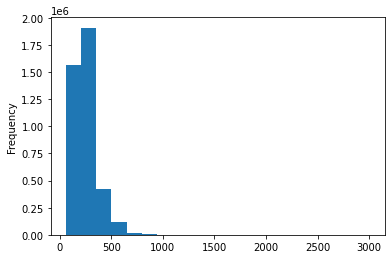

In [35]:
data.height.plot(kind="hist", bins=20)

In [42]:
data[data.height>=1000].iloc[0,:]["file_path"]

'data/bms-molecular-translation/test/0/0/2/00292aba9aa9.png'

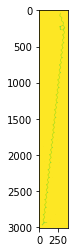

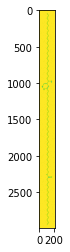

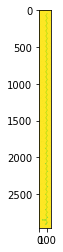

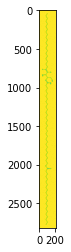

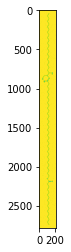

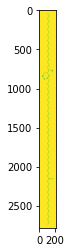

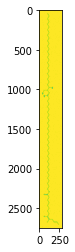

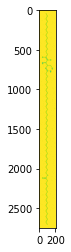

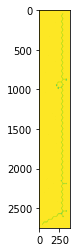

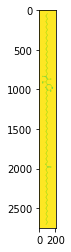

In [47]:
for i in range(10):
    image = imageio.imread(data.sort_values("height", ascending=False).iloc[i,:]["file_path"])
    plt.imshow(image)
    plt.show()

## Convert images to pickle for speed reasons

In [50]:
def create_folder(folder):
    Path(folder).mkdir(parents=True, exist_ok=True)

In [51]:
def process(image):
    image = abs(image/255-1)
    return image

In [61]:
def convert_image(path):
    image = imageio.imread(path)
    image = process(image)
    
    path_list = path.split("/")
    path_list.insert(2, "pickle")
    
    create_folder("/".join(path_list[:-1]))
    
    outpath = "/".join(path_list)
    outpath = outpath[:-3] + "pkl"
    
    pickle.dump(image, open(outpath, "wb"))

In [62]:
data["file_path"].progress_apply(convert_image)

 12%|█▏        | 480342/4040293 [14:39<1:48:36, 546.27it/s]


OSError: [Errno 28] No space left on device